# 1. CCS Faciltiy emissions analysis 

Here are the point-source facilities emissions where amine-based CCS technology is applied. The case presented in here is over the Louisanna State. The data in the below presents the NEI2020 emissions (as "_old") as well as modified emissions by the CCS technology (without "_old") for major air pollutants. 

In [20]:
import geopandas as gpd

# read base and sens emission scenarios
gdf_CS_emis = gpd.read_file(
    #'/Users/yunhalee/Documents/LOCAETA/RCM/INMAP/evaldata_v1.6.1/2020_nei_emissions/combined_NEI2020_pt_oilgas_ptegu_ptnonipm.shp')
    '/Users/yunhalee/Documents/LOCAETA/CS_emissions/Colorado_point_CCS_reduced_emis.shp')

# Reset index to ensure proper comparison
gdf_CS_emis.reset_index(drop=True, inplace=True)

# def subset_data(final_df, state_fips=None):
#     if state_fips:
#         # Match the first two digits of FIPS with State FIPS code
#         return final_df[final_df['FIPS'].astype(str).str[:2] == str(state_fips)]
#     return final_df

# # Dictionary to loop over
# regions = {"LA": '22'} #, "Nation": None}

# final_df = gpd.GeoDataFrame(gdf_CS_emis, geometry= "geometry")
# type(final_df)

# for region_name, state_fips in regions.items():
    
#     # Subset the DataFrame based on the chosen state or national
#     final_df_subset = subset_data(final_df, state_fips)

#     print(f"Processing data for: {region_name}")


In [21]:

# IMPORTANT NOTE : This subset function doesn't include total emissions by EIS_ID. Some cases,     
def subset_pollutants_with_difference(df, pollutants):
    mask = False  # Initialize a mask to filter rows
    for pollutant in pollutants:
        col_current = pollutant
        col_old = f'{pollutant}_old'
        
        if col_current in df.columns and col_old in df.columns:
            # Check where the pollutant and its "_old" version differ
            mask |= (df[col_current] != df[col_old])

    # Subset the dataframe based on the mask
    return df[mask]

pollutants = ['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5']
subset_df = subset_pollutants_with_difference(gdf_CS_emis, pollutants)

subset_df

,FIPS,SCC,VOC_old,NOx_old,NH3_old,SOx_old,PM2_5_old,height,diam,temp,...,PM25CON_re,NOx,SOx,PM25FIL_ou,PM25CON_ou,PM2_5,PM25_reduc,VOC,NH3,geometry
0,08001,20100201,2.2000,99.3000,0.000,1.8000,12.7001,22.8600,5.54736,666.66667,...,6.482381,71.496000,0.018000,0.174119,0.413769,0.587888,12.112213,2.494518,28.113070,POINT (-652329.196 -711.107)
1,08123,20100202,0.0019,0.0400,0.000,0.0002,0.0073,24.3840,1.06680,180.55556,...,0.003115,0.028800,0.000002,0.000120,0.000199,0.000318,0.006982,1.837425,175.209220,POINT (-641913.733 36890.849)
2,08123,20100201,5.7767,146.7000,0.000,7.7000,19.3002,53.3400,5.63880,89.44444,...,9.851209,105.624000,0.077000,0.264606,0.628801,0.893406,18.406794,7.612225,175.209220,POINT (-641913.733 36890.849)
3,08123,10100602,0.4150,7.5450,0.000,0.0440,0.1446,31.0896,1.06680,333.33333,...,0.085360,5.432400,0.000440,0.001614,0.005449,0.007062,0.137538,3.097226,256.030706,POINT (-663965.526 55833.920)
4,08123,20100201,16.3000,439.5000,93.159,9.2100,55.3695,53.3400,4.57200,100.00000,...,28.261692,316.440000,0.092100,0.759116,1.803938,2.563054,52.806446,18.982226,349.189706,POINT (-663965.526 55833.920)
5,08001,20200202,34.9663,403.8390,0.000,0.1632,12.5160,10.0584,0.30480,416.66667,...,4.470715,290.764080,0.001632,0.232798,0.285365,0.518162,11.997838,35.067039,9.615961,POINT (-653903.448 -533.739)
6,08031,10200601,2.1211,108.6608,0.000,0.1043,0.7919,8.5344,1.98120,333.33333,...,0.471196,78.235776,0.001043,0.008719,0.030076,0.038795,0.753105,2.256191,12.895092,POINT (-679227.134 2908.884)
7,08031,10100601,1.4296,6.4236,0.000,0.2159,0.5373,15.2400,1.52400,169.44444,...,0.309603,4.624992,0.002159,0.006238,0.019762,0.026000,0.511300,1.564691,12.895092,POINT (-679227.366 2910.126)
8,08059,20100102,0.0014,0.0510,0.000,0.0000,0.0016,7.6200,0.30480,583.33333,...,0.000362,0.036720,0.000000,0.000036,0.000023,0.000060,0.001540,0.101472,9.552287,POINT (-688809.493 7519.325)
9,08059,30290003,0.0400,0.7400,0.000,0.0040,0.0500,18.2880,1.21920,94.44444,...,0.025004,0.532800,0.000040,0.000702,0.001596,0.002298,0.047702,0.484574,42.436624,POINT (-696642.109 5443.609)


The cobenefits code, which process the air quality emissions based on the CCS technology, generates higher emissions of NOx and SOx for 1-2 facilities, which appears bug in the code. The dataframe below shows two facilities with higher SOx emission by CCS. 

In [22]:
# Find the case where SOx is higher than SOx_old
if 'NH3' in subset_df.columns and 'NH3_new' in subset_df.columns:
    filtered_df = subset_df[subset_df['NH3'] != subset_df['NH3_new']]

filtered_df.head()

,FIPS,SCC,VOC,NOx_old,NH3,SOx_old,PM2_5_old,height,diam,temp,...,PM25CON_re,NOx,SOx,PM25FIL_ou,PM25CON_ou,PM2_5,PM25_reduc,VOC_new,NH3_new,geometry
0,08001,20100201,2.2000,99.300,0.000,1.8000,12.7001,22.8600,5.54736,666.66667,...,6.482381,71.4960,0.018000,0.174119,0.413769,0.587888,12.112213,2.494518,28.113070,POINT (-652329.196 -711.107)
1,08123,20100202,0.0019,0.040,0.000,0.0002,0.0073,24.3840,1.06680,180.55556,...,0.003115,0.0288,0.000002,0.000120,0.000199,0.000318,0.006982,1.837425,175.209220,POINT (-641913.733 36890.849)
2,08123,20100201,5.7767,146.700,0.000,7.7000,19.3002,53.3400,5.63880,89.44444,...,9.851209,105.6240,0.077000,0.264606,0.628801,0.893406,18.406794,7.612225,175.209220,POINT (-641913.733 36890.849)
3,08123,10100602,0.4150,7.545,0.000,0.0440,0.1446,31.0896,1.06680,333.33333,...,0.085360,5.4324,0.000440,0.001614,0.005449,0.007062,0.137538,3.097226,256.030706,POINT (-663965.526 55833.920)
4,08123,20100201,16.3000,439.500,93.159,9.2100,55.3695,53.3400,4.57200,100.00000,...,28.261692,316.4400,0.092100,0.759116,1.803938,2.563054,52.806446,18.982226,349.189706,POINT (-663965.526 55833.920)


The dataframe below shows the facility with higher NOx emission by CCS. The incorrect emissions are very small (total 0.5 tons for NOx and 4 tons for SOx), and it is unlikely affect our overall results. Nevertheless, these emissions should be fixed from the cobenefits code in future. Otherwise, I need to manually remove these emissions. 

In [23]:
# Find the case where NOx is higher than NOx_old
if 'NOx' in subset_df.columns and 'NOx_old' in subset_df.columns:
    filtered_NOx_df = subset_df[subset_df['NOx'] != subset_df['NOx_old']]

filtered_NOx_df.head()

,FIPS,SCC,VOC_old,NOx_old,NH3_old,SOx_old,PM2_5_old,height,diam,temp,...,PM25CON_re,NOx,SOx,PM25FIL_ou,PM25CON_ou,PM2_5,PM25_reduc,VOC,NH3,geometry
0,08001,20100201,2.2000,99.300,0.000,1.8000,12.7001,22.8600,5.54736,666.66667,...,6.482381,71.4960,0.018000,0.174119,0.413769,0.587888,12.112213,2.494518,28.113070,POINT (-652329.196 -711.107)
1,08123,20100202,0.0019,0.040,0.000,0.0002,0.0073,24.3840,1.06680,180.55556,...,0.003115,0.0288,0.000002,0.000120,0.000199,0.000318,0.006982,1.837425,175.209220,POINT (-641913.733 36890.849)
2,08123,20100201,5.7767,146.700,0.000,7.7000,19.3002,53.3400,5.63880,89.44444,...,9.851209,105.6240,0.077000,0.264606,0.628801,0.893406,18.406794,7.612225,175.209220,POINT (-641913.733 36890.849)
3,08123,10100602,0.4150,7.545,0.000,0.0440,0.1446,31.0896,1.06680,333.33333,...,0.085360,5.4324,0.000440,0.001614,0.005449,0.007062,0.137538,3.097226,256.030706,POINT (-663965.526 55833.920)
4,08123,20100201,16.3000,439.500,93.159,9.2100,55.3695,53.3400,4.57200,100.00000,...,28.261692,316.4400,0.092100,0.759116,1.803938,2.563054,52.806446,18.982226,349.189706,POINT (-663965.526 55833.920)


In [24]:
subset_df.shape

(19, 35)

In [36]:
import contextily as ctx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import os

# Function to plot the percent change of each pollutant and its "_old" version with a basemap
def plot_spatial_distribution_percent_change_with_basemap(gdf, output_dir):
    pollutants = ['NH3', 'VOC', 'NOx',  'SOx', 'PM2_5'] # 
    
    # Ensure the GeoDataFrame is in the correct CRS for basemaps (Web Mercator)
    gdf = gdf.to_crs(epsg=3857)

    for pollutant in pollutants:
        fig, ax = plt.subplots(figsize=(9, 6))

        col_current = f'{pollutant}'
        col_old = f'{pollutant}_old'

        # Ensure both the current and "_old" columns exist in the GeoDataFrame
        if col_current not in gdf.columns or col_old not in gdf.columns:
            print(f'Columns {col_current} or {col_old} do not exist in the data.')
            continue
        
        # Calculate the percent change, avoiding division by zero
        gdf['percent_change'] = ((gdf[col_current] - gdf[col_old]) / gdf[col_old].replace(0, float('nan'))) * 100

        # Plot the spatial distribution of the percent change
        vmin, vmax = -100, 100  # Fixed color scale from -50% to 50%

        if pollutant == 'NH3':
            vmin, vmax = -200, 200 

        gdf.plot(column='percent_change', cmap='coolwarm', vmin=vmin, vmax=vmax, legend=False, edgecolor='black', 
                 ax=ax, markersize=30, alpha=0.95)  # Increase marker size and reduce transparency

        print(ax)
        print(ax.get_xlim(), ax.get_ylim())
        
        # Add a basemap (using OpenStreetMap)
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

        ax.set_title(f'Percent Change in {pollutant} emissions by amine-based CCS')

        # Calculate the total, max, and min percent change
        total_current = gdf[col_current].sum()
        total_old = gdf[col_old].sum()
        total_percent_change = ((total_current - total_old) / total_old) * 100
        max_percent_change = gdf['percent_change'].max()
        min_percent_change = gdf['percent_change'].min()

        # Display the total, max, and min percent changes on the plot
        ax.text(0.5, -0.15, f'Total Percent Change: {total_percent_change:.2f}%\nMax Percent Change: {max_percent_change:.2f}%\nMin Percent Change: {min_percent_change:.2f}%', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')

        # Add a color bar for the pollutant
        sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
        sm._A = []
        cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # Position color bar to avoid overlap
        fig.colorbar(sm, cax=cbar_ax).set_label(f'{pollutant} Percent Change', rotation=270, labelpad=15)

        # Tighter layout with specific margins
        plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the right margin to make room for colorbar

        # Save the figure for each pollutant as a separate file
        plt.savefig(os.path.join(output_dir, f'{pollutant}_percent_change_with_basemap.png'), dpi=300, bbox_inches='tight')
        plt.close()  # Close the figure to avoid overlapping plots

# Example usage
output_dir = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/'
plot_spatial_distribution_percent_change_with_basemap(subset_df, output_dir)


Axes(0.125,0.250963;0.775x0.488074)
(-12316651.776491312, -11032451.117331078) (4631961.380270929, 5171131.488027333)


/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_75683/1187246656.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the right margin to make room for colorbar


Axes(0.272538,0.11;0.479924x0.77)
(-11714868.917447722, -11640092.721175117) (4825200.3020505775, 4905181.964249062)


/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_75683/1187246656.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the right margin to make room for colorbar


Axes(0.272538,0.11;0.479924x0.77)
(-11714868.917447722, -11640092.721175117) (4825200.3020505775, 4905181.964249062)


/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_75683/1187246656.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the right margin to make room for colorbar


Axes(0.272538,0.11;0.479924x0.77)
(-11714868.917447722, -11640092.721175117) (4825200.3020505775, 4905181.964249062)


/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_75683/1187246656.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the right margin to make room for colorbar


Axes(0.272538,0.11;0.479924x0.77)
(-11714868.917447722, -11640092.721175117) (4825200.3020505775, 4905181.964249062)


/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_75683/1187246656.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the right margin to make room for colorbar


In [39]:
def plot_spatial_distribution_percent_change_with_basemap(gdf, output_dir):
    pollutants = ['NH3', 'VOC', 'NOx', 'SOx', 'PM2_5']
    
    # Ensure the GeoDataFrame is in the correct CRS for basemaps
    gdf = gdf.to_crs(epsg=3857)
    
    for pollutant in pollutants:
        # Use gridspec for more precise layout control
        fig = plt.figure(figsize=(10, 6))
        gs = fig.add_gridspec(1, 20)  # Create a 1×20 grid for precise width control
        
        # Main plot takes 18/20 of the width
        ax = fig.add_subplot(gs[0, :19])
        
        col_current = f'{pollutant}'
        col_old = f'{pollutant}_old'
        
        if col_current not in gdf.columns or col_old not in gdf.columns:
            print(f'Columns {col_current} or {col_old} do not exist in the data.')
            continue
        
        # Calculate percent change
        gdf['percent_change'] = ((gdf[col_current] - gdf[col_old]) / gdf[col_old].replace(0, float('nan'))) * 100
        
        # Set color scale
        vmin, vmax = -100, 100
        if pollutant == 'NH3':
            vmin, vmax = -200, 200
        
        # Plot data
        gdf.plot(column='percent_change', cmap='coolwarm', vmin=vmin, vmax=vmax, 
                legend=False, edgecolor='black', ax=ax, markersize=30, alpha=0.95)
        
        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)
        
        # Set title
        ax.set_title(f'Percent Change in {pollutant} emissions by amine-based CCS')
        
        # Calculate statistics
        total_current = gdf[col_current].sum()
        total_old = gdf[col_old].sum()
        total_percent_change = ((total_current - total_old) / total_old) * 100
        max_percent_change = gdf['percent_change'].max()
        min_percent_change = gdf['percent_change'].min()
        
        # Display statistics
        ax.text(0.5, -0.15, f'Total Percent Change: {total_percent_change:.2f}%\nMax Percent Change: {max_percent_change:.2f}%\nMin Percent Change: {min_percent_change:.2f}%',
                ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')
        
        # Create colorbar in the last 1/20 columns of the grid
        cbar_ax = fig.add_subplot(gs[0, 19:])
        sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
        sm._A = []
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label(f'{pollutant} Percent Change', rotation=270, labelpad=15)
        
        # Minimize spacing between elements
        plt.subplots_adjust(wspace=0.05)  # Very small spacing between map and colorbar
        
        # Save figure
        plt.savefig(os.path.join(output_dir, f'{pollutant}_percent_change_with_basemap.png'), dpi=300, bbox_inches='tight')
        plt.close()

# Example usage
output_dir = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/'
plot_spatial_distribution_percent_change_with_basemap(subset_df, output_dir)

In [ ]:
# Function to plot the percent change of each pollutant and its "_old" version with a basemap
def plot_spatial_distribution_relative_difference_with_basemap(gdf, output_dir):
    pollutants = ['NH3', 'VOC', 'NOx',  'SOx', 'PM2_5'] # 
    
    # Ensure the GeoDataFrame is in the correct CRS for basemaps (Web Mercator)
    gdf = gdf.to_crs(epsg=3857)

    for pollutant in pollutants:
        fig, ax = plt.subplots(figsize=(9, 6))

        col_current = f'{pollutant}'
        col_old = f'{pollutant}_old'

        # Ensure both the current and "_old" columns exist in the GeoDataFrame
        if col_current not in gdf.columns or col_old not in gdf.columns:
            print(f'Columns {col_current} or {col_old} do not exist in the data.')
            continue
        
        # Calculate the percent change, avoiding division by zero
        gdf['reverse_percent_change'] = ((gdf[col_old] - gdf[col_current]) / gdf[col_current].replace(0, float('nan'))) * 100

        # Plot the spatial distribution of the percent change
        vmin, vmax = -100, 100  # Fixed color scale from -50% to 50%

        if pollutant == 'NH3':
            vmin, vmax = -200, 200 

        gdf.plot(column='reverse_percent_change', cmap='coolwarm', vmin=vmin, vmax=vmax, legend=False, edgecolor='black', 
                 ax=ax, markersize=30, alpha=0.95)  # Increase marker size and reduce transparency

        # Add a basemap (using OpenStreetMap)
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

        ax.set_title(f'Relative Difference in {pollutant} NEI 2020 Emissions Compared to Amine-Based CCS Emissions')

        # Calculate the total, max, and min percent change
        total_current = gdf[col_current].sum()
        total_old = gdf[col_old].sum()
        total_percent_change = ((total_old - total_current) / total_current) * 100
        max_percent_change = gdf['reverse_percent_change'].max()
        min_percent_change = gdf['reverse_percent_change'].min()

        # Display the total, max, and min percent changes on the plot
        ax.text(0.5, -0.15, f'Total Relative Difference: {total_percent_change:.2f}%\nMax Relative Difference: {max_percent_change:.2f}%\nMin Relative Difference: {min_percent_change:.2f}%', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')

        # Add a color bar for the pollutant
        sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
        sm._A = []
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position color bar to avoid overlap
        fig.colorbar(sm, cax=cbar_ax).set_label(f'{pollutant} Relative Difference')

        # Adjust layout to prevent overlap
        plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.2)

        # Save the figure for each pollutant as a separate file
        plt.savefig(os.path.join(output_dir, f'{pollutant}_Relative_Difference_with_basemap.png'), dpi=300, bbox_inches='tight')
        plt.close()  # Close the figure to avoid overlapping plots

# Example usage
output_dir = '/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/'
plot_spatial_distribution_relative_difference_with_basemap(subset_df, output_dir)

To spatial distribution of the emissions changes by amine-based CCS technology are presented here. It shows the percent changes computed using the difference between the emissions with CCS and the original NEI2020 emissions divided by the NEI2020 emissions. For Primary PM2.5, NOx and SOx, it shows negative percent changes because the CCS tech reduces their emissions. For VOC, the percent changes are only slightly positive. 
<table>
  <tr>
    <td><img src="/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/PM2_5_percent_change_with_basemap.png" alt="PM2.5" width="400"/></td>
    <td><img src="/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/VOC_percent_change_with_basemap.png" alt="VOC" width="400"/></td>
  </tr>
  <tr>
    <td><img src="/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/NOx_percent_change_with_basemap.png" alt="NOx" width="400"/></td>
    <td><img src="/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/SOx_percent_change_with_basemap.png" alt="SOx" width="400"/></td>
  </tr>
</table>

The amine-based CCS technology increases NH3 emissions significatly. Several point-source facilities with zero NH3 emissions in the NEI2020 emission inventory have positive NH3 emissions. Since the percent changes calculation used for other pollutants uses the NEI2020 emissions as dinominator, it drops out several facilities with zero NH3 emissions in the NEI2020 inventory. Thus, the percent change calculation used for NH3 is based on the emissions with CCS, instead of the NEI2020 emissions - it computes using the difference between the original NEI2020 emissions and the emissions with CCS, divided by the CCS emissions. The percent changes for other pollutants show how the CCS technology changes their emissions from the NEI2020 inventory while the one for NH3 shows how the NEI2020 inventory changes its emission from the CCS emissions. 
<td><img src="/Users/yunhalee/Documents/LOCAETA/LOCAETA_AQ/outputs/emissions/CO_CCS/NH3_Relative_Difference_with_basemap.png" alt="NH3" width="800"/></td>

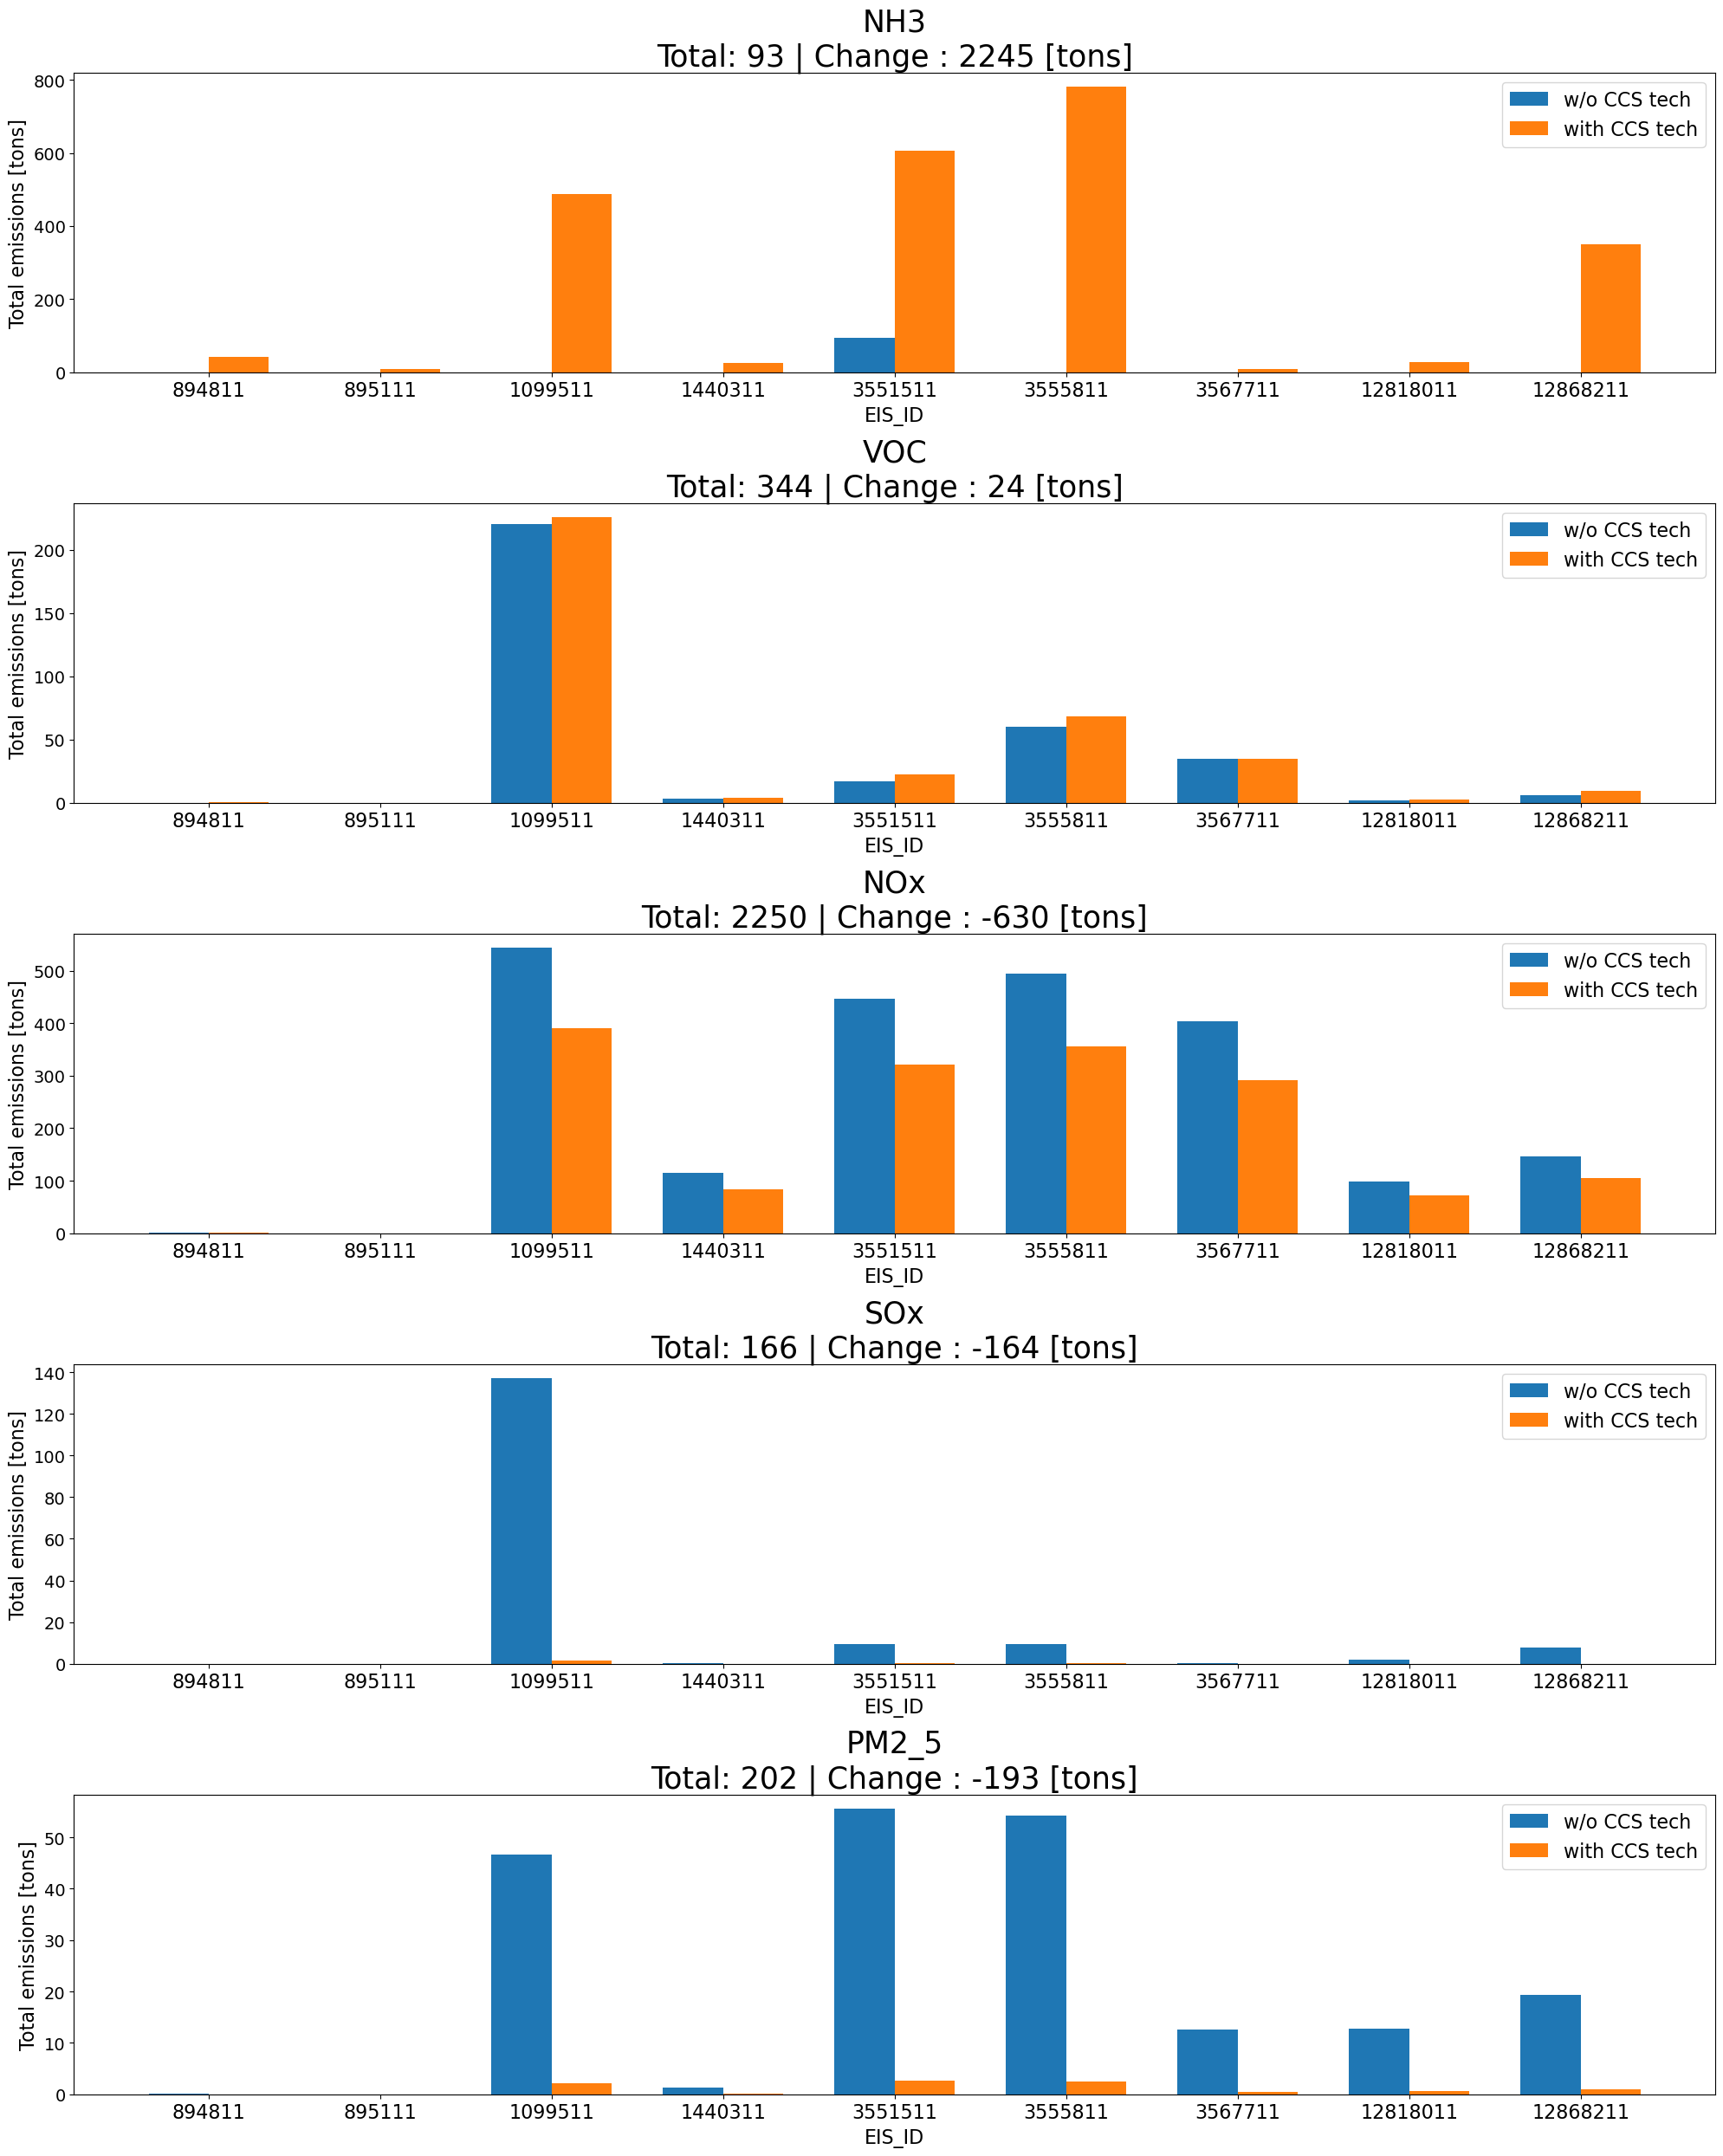

In [33]:
import numpy as np

# sum by FIPS
grouped_df = subset_df.drop(columns='geometry').groupby('EIS_ID').sum().reset_index()

pollutants = ['NH3', 'VOC', 'NOx',  'SOx', 'PM2_5'] # 
pollutants_old = [f'{pollutant}_old' for pollutant in pollutants]

# Calculate total sums for each pollutant
totals = {pollutant: subset_df[pollutant].sum() for pollutant in pollutants_old}
totals_CCS ={pollutant: subset_df[pollutant].sum() for pollutant in pollutants}

# Plotting
fig, axes = plt.subplots(nrows=len(pollutants), ncols=1, figsize=(20, 25) ) #, sharey=True)
bar_width = 0.35  # Width of the bars
for i, pollutant in enumerate(pollutants):
    ax = axes[i]
    indices = np.arange(len(grouped_df))

    # Plot NEI2020
    ax.bar(indices, grouped_df[pollutants_old[i]], bar_width, label=f'{pollutants_old[i]}')

    # Plot CCS emissions
    ax.bar(indices  + bar_width, grouped_df[pollutant], bar_width, label=f'{pollutant}')
    
    total_original = totals[f'{pollutant}_old']
    total_new = totals_CCS[f'{pollutant}']
    ax.set_title(f'{pollutant}\nTotal: {total_original:.0f} | Change : {(total_new - total_original):.0f} [tons]', fontsize=25)
    ax.set_xlabel('EIS_ID', fontsize=16)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('Total emissions [tons]', fontsize=16)
    ax.set_xticks(indices + bar_width / 2)
    ax.set_xticklabels(grouped_df['EIS_ID'], rotation=0, fontsize=16)
    ax.legend(["w/o CCS tech", "with CCS tech",], fontsize=16)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, f'total_Difference.png'), dpi=300, bbox_inches='tight')

plt.show()

In [28]:
import pandas as pd

# Add Landfill into the subset_df for plotting

# Apply CCS emissions to a facility of interest
facility_eis_id = {'Landfill': 2001411} # 'Suncor':1099511 } # 'Cherokee':3555811 } 
                   #'Suncor':1099511, } # 17445711} # Suncor frs_id = '1007923'
		# Cherokee plant alone (facility ID 1007207)  EIS_ID = 17445711
        # NEI emission without landfill facility ID 1007709

for key, id in facility_eis_id.items():

    if isinstance(id, int):
        print(f"{id} is integer")
    else:
        print(f"{id} must be integer")
        id = int(id)

    print(f"matching facility: {gdf_CS_emis[gdf_CS_emis['EIS_ID'] == id]}" )

    landfill_df = gdf_CS_emis[gdf_CS_emis['EIS_ID'] == id]

print("before merging", subset_df.shape)
subset_df = gpd.GeoDataFrame(pd.concat([subset_df, landfill_df], ignore_index=True) )
print("after merging", subset_df.shape)
grouped_df = subset_df.drop(columns='geometry').groupby('EIS_ID').sum().reset_index()


2001411 is integer
matching facility: Empty GeoDataFrame
Columns: [FIPS, SCC, VOC_old, NOx_old, NH3_old, SOx_old, PM2_5_old, height, diam, temp, velocity, EIS_ID, ghgrp_faci, NOX_subpar, SO2_subpar, VOC_subpar, NH3_subpar, PM25FIL_su, PM25CON_su, PM25_subpa, NOX_reduct, SO2_reduct, VOC_increa, NH3_increa, PM25FIL_re, PM25CON_re, NOx, SOx, PM25FIL_ou, PM25CON_ou, PM2_5, PM25_reduc, VOC, NH3, geometry]
Index: []

[0 rows x 35 columns]
before merging (19, 35)
after merging (19, 35)


In [29]:
import pandas as pd
from tabulate import tabulate

# Create a table with EIS_ID, CCS emissions, and NEI2020 emissions
table_data = grouped_df[['EIS_ID']].copy()
for i, pollutant in enumerate(pollutants):
    table_data[pollutant] = grouped_df[pollutant]
    table_data[pollutants_old[i]] = grouped_df[pollutants_old[i]]

table_data.to_csv(os.path.join(output_dir, f'Denver_facility_total_emissions.csv'))
# Print the table in a pretty format
print(tabulate(table_data, headers='keys', tablefmt='pretty'))

+---+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+----------+---------------------+-------------+--------------------+
|   |   EIS_ID   |        NH3         |      NH3_old      |        VOC         |      VOC_old       |        NOx         |      NOx_old       |   SOx    |       SOx_old       |    PM2_5    |     PM2_5_old      |
+---+------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+----------+---------------------+-------------+--------------------+
| 0 |  894811.0  |     42.4366236     |        0.0        |    0.484574152     |        0.04        |       0.5328       |        0.74        |  4e-05   |        0.004        |  0.002298   |        0.05        |
| 1 |  895111.0  |     9.5522868      |        0.0        |    0.101471576     |       0.0014       |      0.03672       |       0.051        |   0.0   

{'NH3': 93.15899999999999, 'VOC': 343.5066, 'NOx': 2250.4361, 'SOx': 165.6326, 'PM2_5': 202.2023}


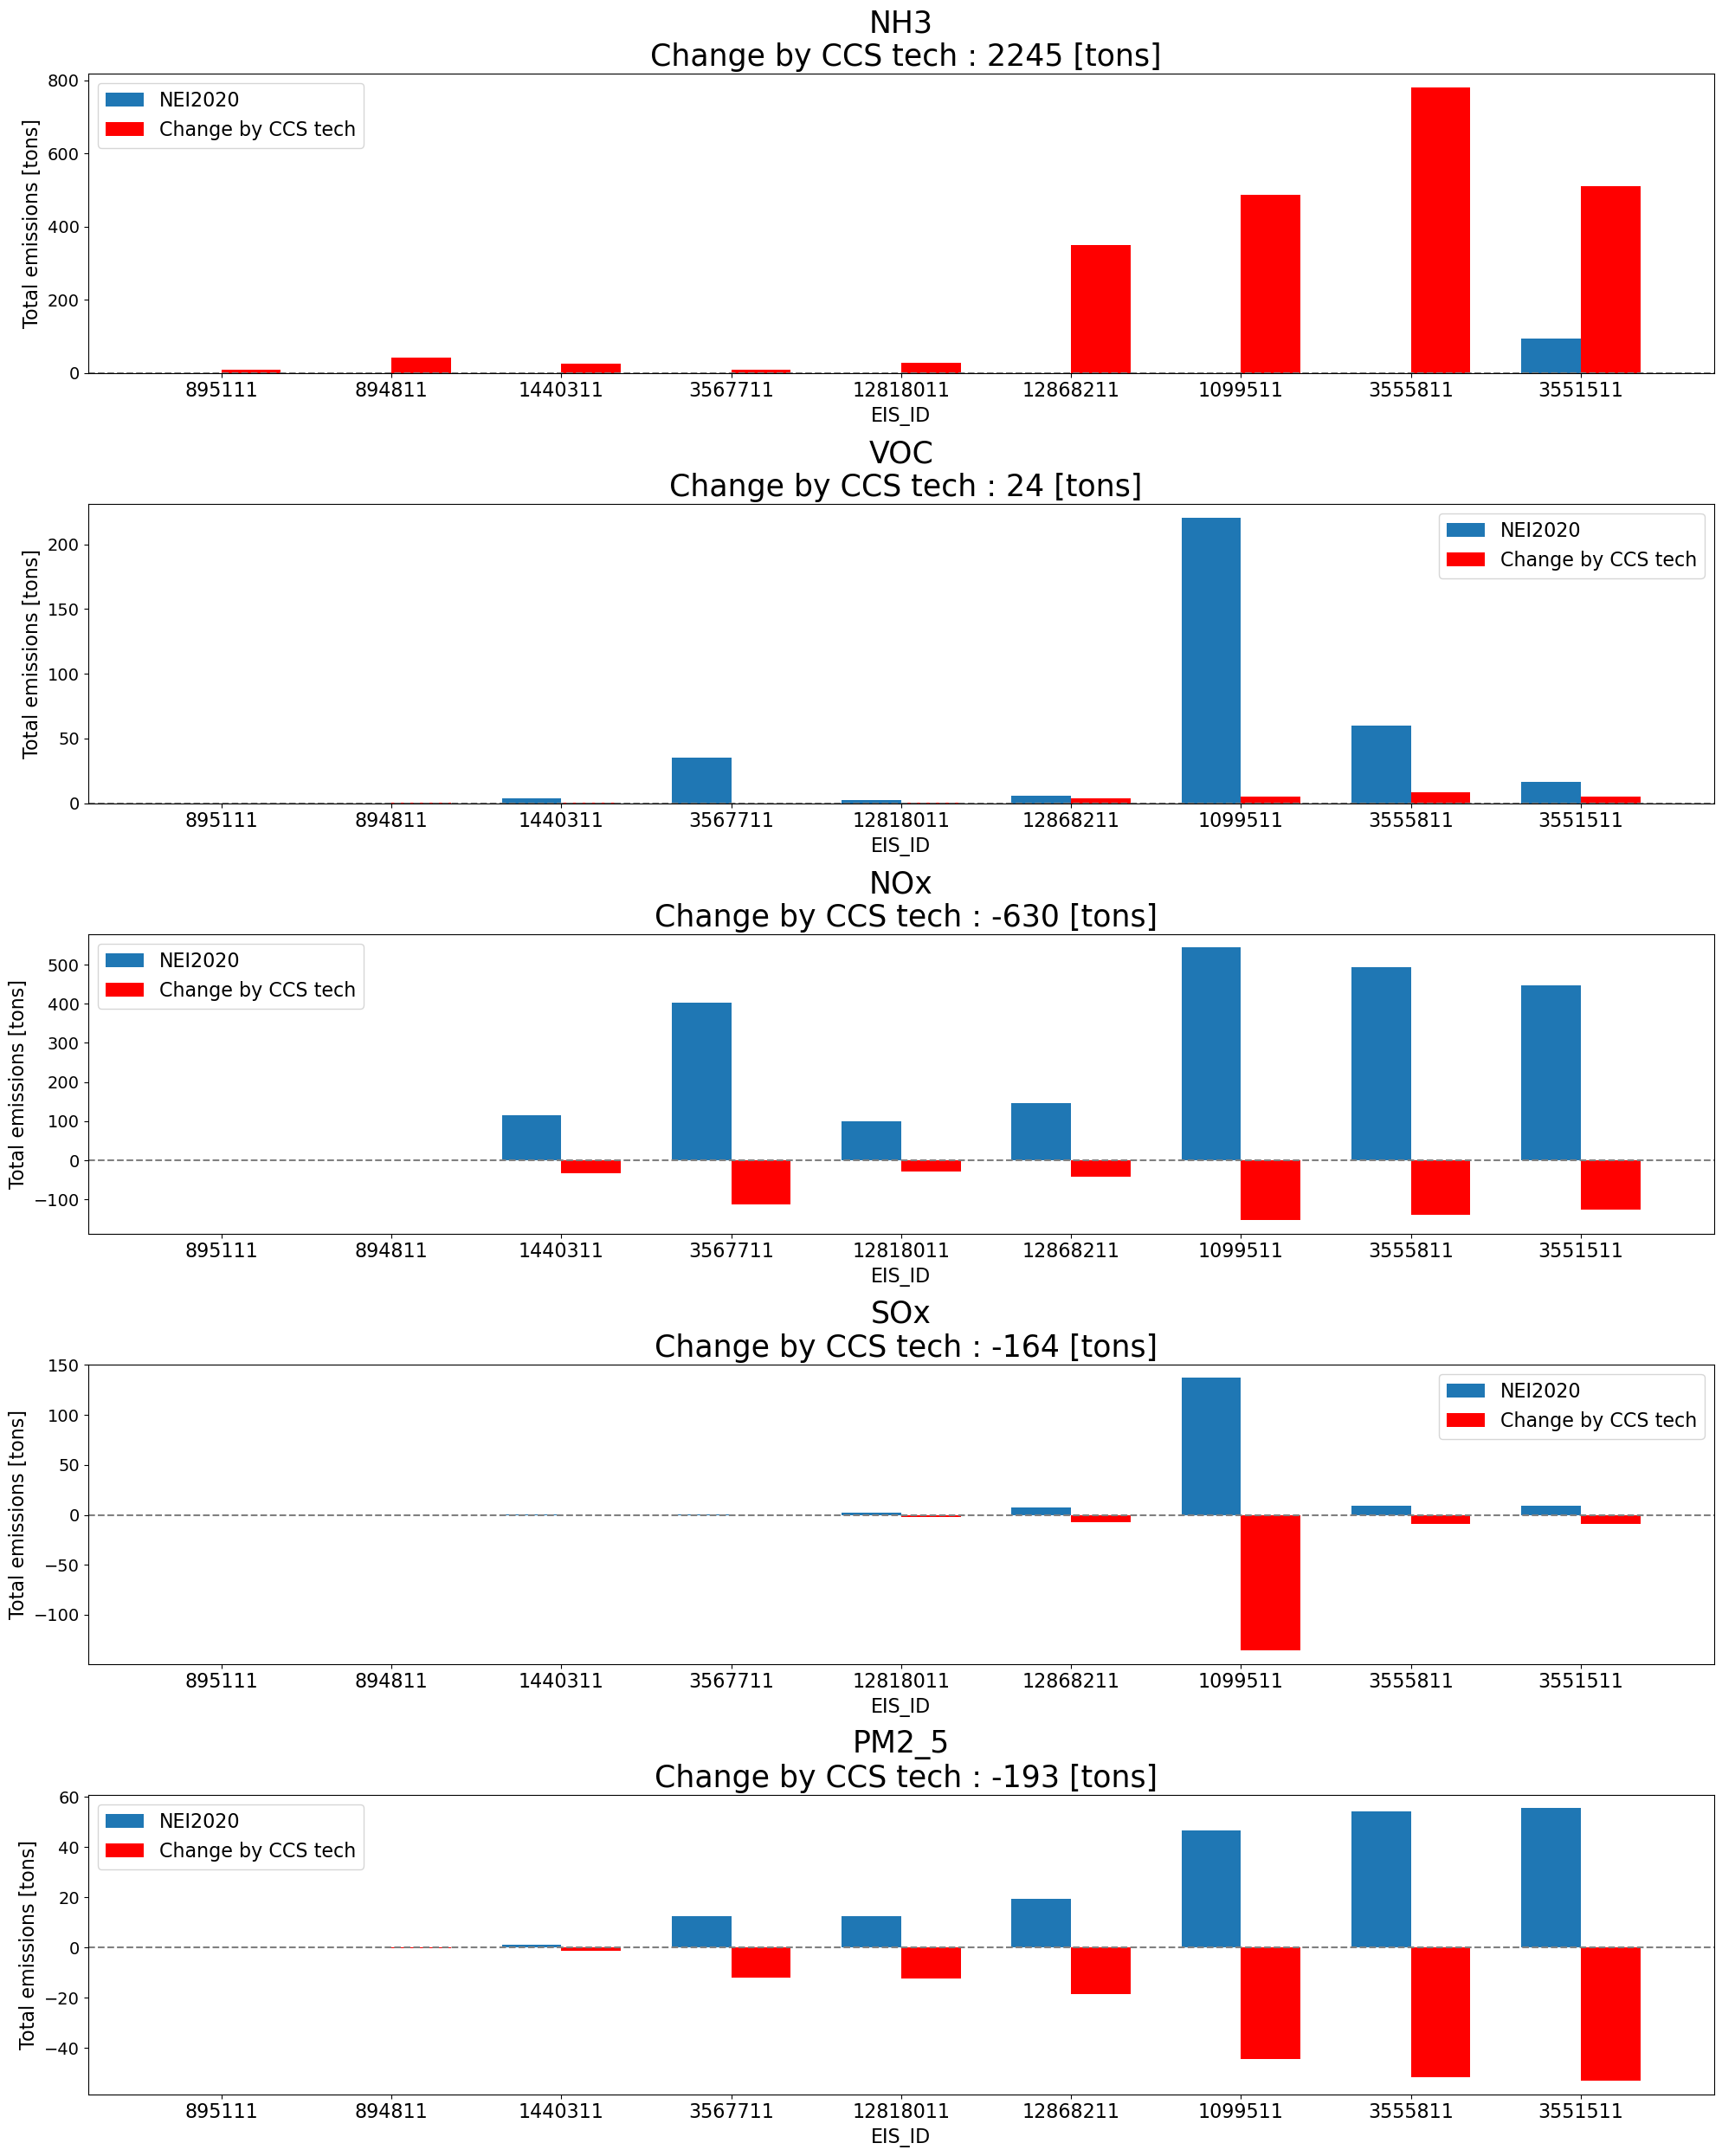

In [34]:
# Plotting
pollutants = ['NH3', 'VOC', 'NOx',  'SOx', 'PM2_5'] # 
pollutants_old = [f'{pollutant}_old' for pollutant in pollutants]

for i, pollutant in enumerate(pollutants):
    table_data[f'{pollutant}_change'] = table_data[pollutant] - table_data[pollutants_old[i]]

table_data = table_data.sort_values(by='PM2_5_change', ascending=False).reset_index(drop=True)

# Calculate total sums for each pollutant
totals = {pollutant: table_data[f'{pollutant}_old'].sum() for pollutant in pollutants}
totals_change ={pollutant: table_data[f'{pollutant}_change'].sum() for pollutant in pollutants}

print(totals)

fig, axes = plt.subplots(nrows=len(pollutants), ncols=1, figsize=(20, 25)) #, sharey=True)
bar_width = 0.35  # Width of the bars
for i, pollutant in enumerate(pollutants):
    ax = axes[i]
    indices = np.arange(len(table_data))
    # Plot NEI emissions
    bar1 = ax.bar(indices, table_data[f'{pollutant}_old'], bar_width, label=f'{pollutant}')
    
    # Plot NEI2020
    bar2 = ax.bar(indices + bar_width, table_data[f'{pollutant}_change'], bar_width, label=f'{pollutants} change', color ='red')
    
    total_nei = totals[f'{pollutant}']
    total_change_by_ccs = totals_change[f'{pollutant}']
    ax.axhline (y=0, color = 'grey', linestyle='--')
    ax.set_title(f'{pollutant}\n Change by CCS tech : {(total_change_by_ccs):.0f} [tons]', fontsize=25) # {pollutant}\nTotal: {total_nei:.0f} |
    ax.set_xlabel('EIS_ID', fontsize=16 )
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('Total emissions [tons]', fontsize=16 )
    ax.set_xticks(indices + bar_width / 2)
    ax.set_xticklabels(table_data['EIS_ID'], rotation=0, fontsize=16 )
    ax.legend(handles=[bar1, bar2], labels=["NEI2020", "Change by CCS tech"],fontsize=16)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, f'NEI_emissions_CCS_Change.png'), dpi=300, bbox_inches='tight')
plt.show()


The changes in emissions by the CCS technology is also presented in barplot. It shows total emissions in tonnes by each county (FIPS code) for each pollutant. 

In [31]:
from IPython.display import display, Markdown

markdown_text = f"The number of facilties applied with the amine-based CCS technology is **{len(subset_df['EIS_ID'].unique())}**, which is all located in the CO state. "
                 
for i, pollutant in enumerate(pollutants):
    total_original = totals[f'{pollutant}_old']
    change = totals_CCS[f'{pollutant}'] - total_original
    percent_change  = change/total_original * 100 
    # Use Markdown to display the computed value
    markdown_text +=f"For {pollutant}, the total NEI2020 emissions are **{total_original:.0f}** in tons, and it is changed by **{change:.0f}** (**{percent_change:.1f}** %)with amine-based CCS technology. "


# Display the entire paragraph in one go
display(Markdown(markdown_text))

KeyError: 'NH3_old'

# Check a facility emissions from NEI inventory



2001411 is integer
matching facility:          FIPS       SCC     VOC    NOx  NH3   SOx    PM2_5  height     diam  \
127285  08005  20300802   11.08  71.33  0.0  2.72    9.360  8.8392  0.38710   
127286  08005  50100402   29.20   0.00  0.0  0.00  441.523  0.0000  0.00000   
127287  08005  50100410  151.25  29.61  0.0  6.57    7.310  7.6200  3.01752   

              temp  velocity   EIS_ID                       geometry  
127285  366.111110  25.63368  2001411  POINT (-653492.668 -9551.493)  
127286  255.372222   0.00000  2001411  POINT (-653492.668 -9551.493)  
127287  648.888890   3.47472  2001411  POINT (-653492.668 -9551.493)  


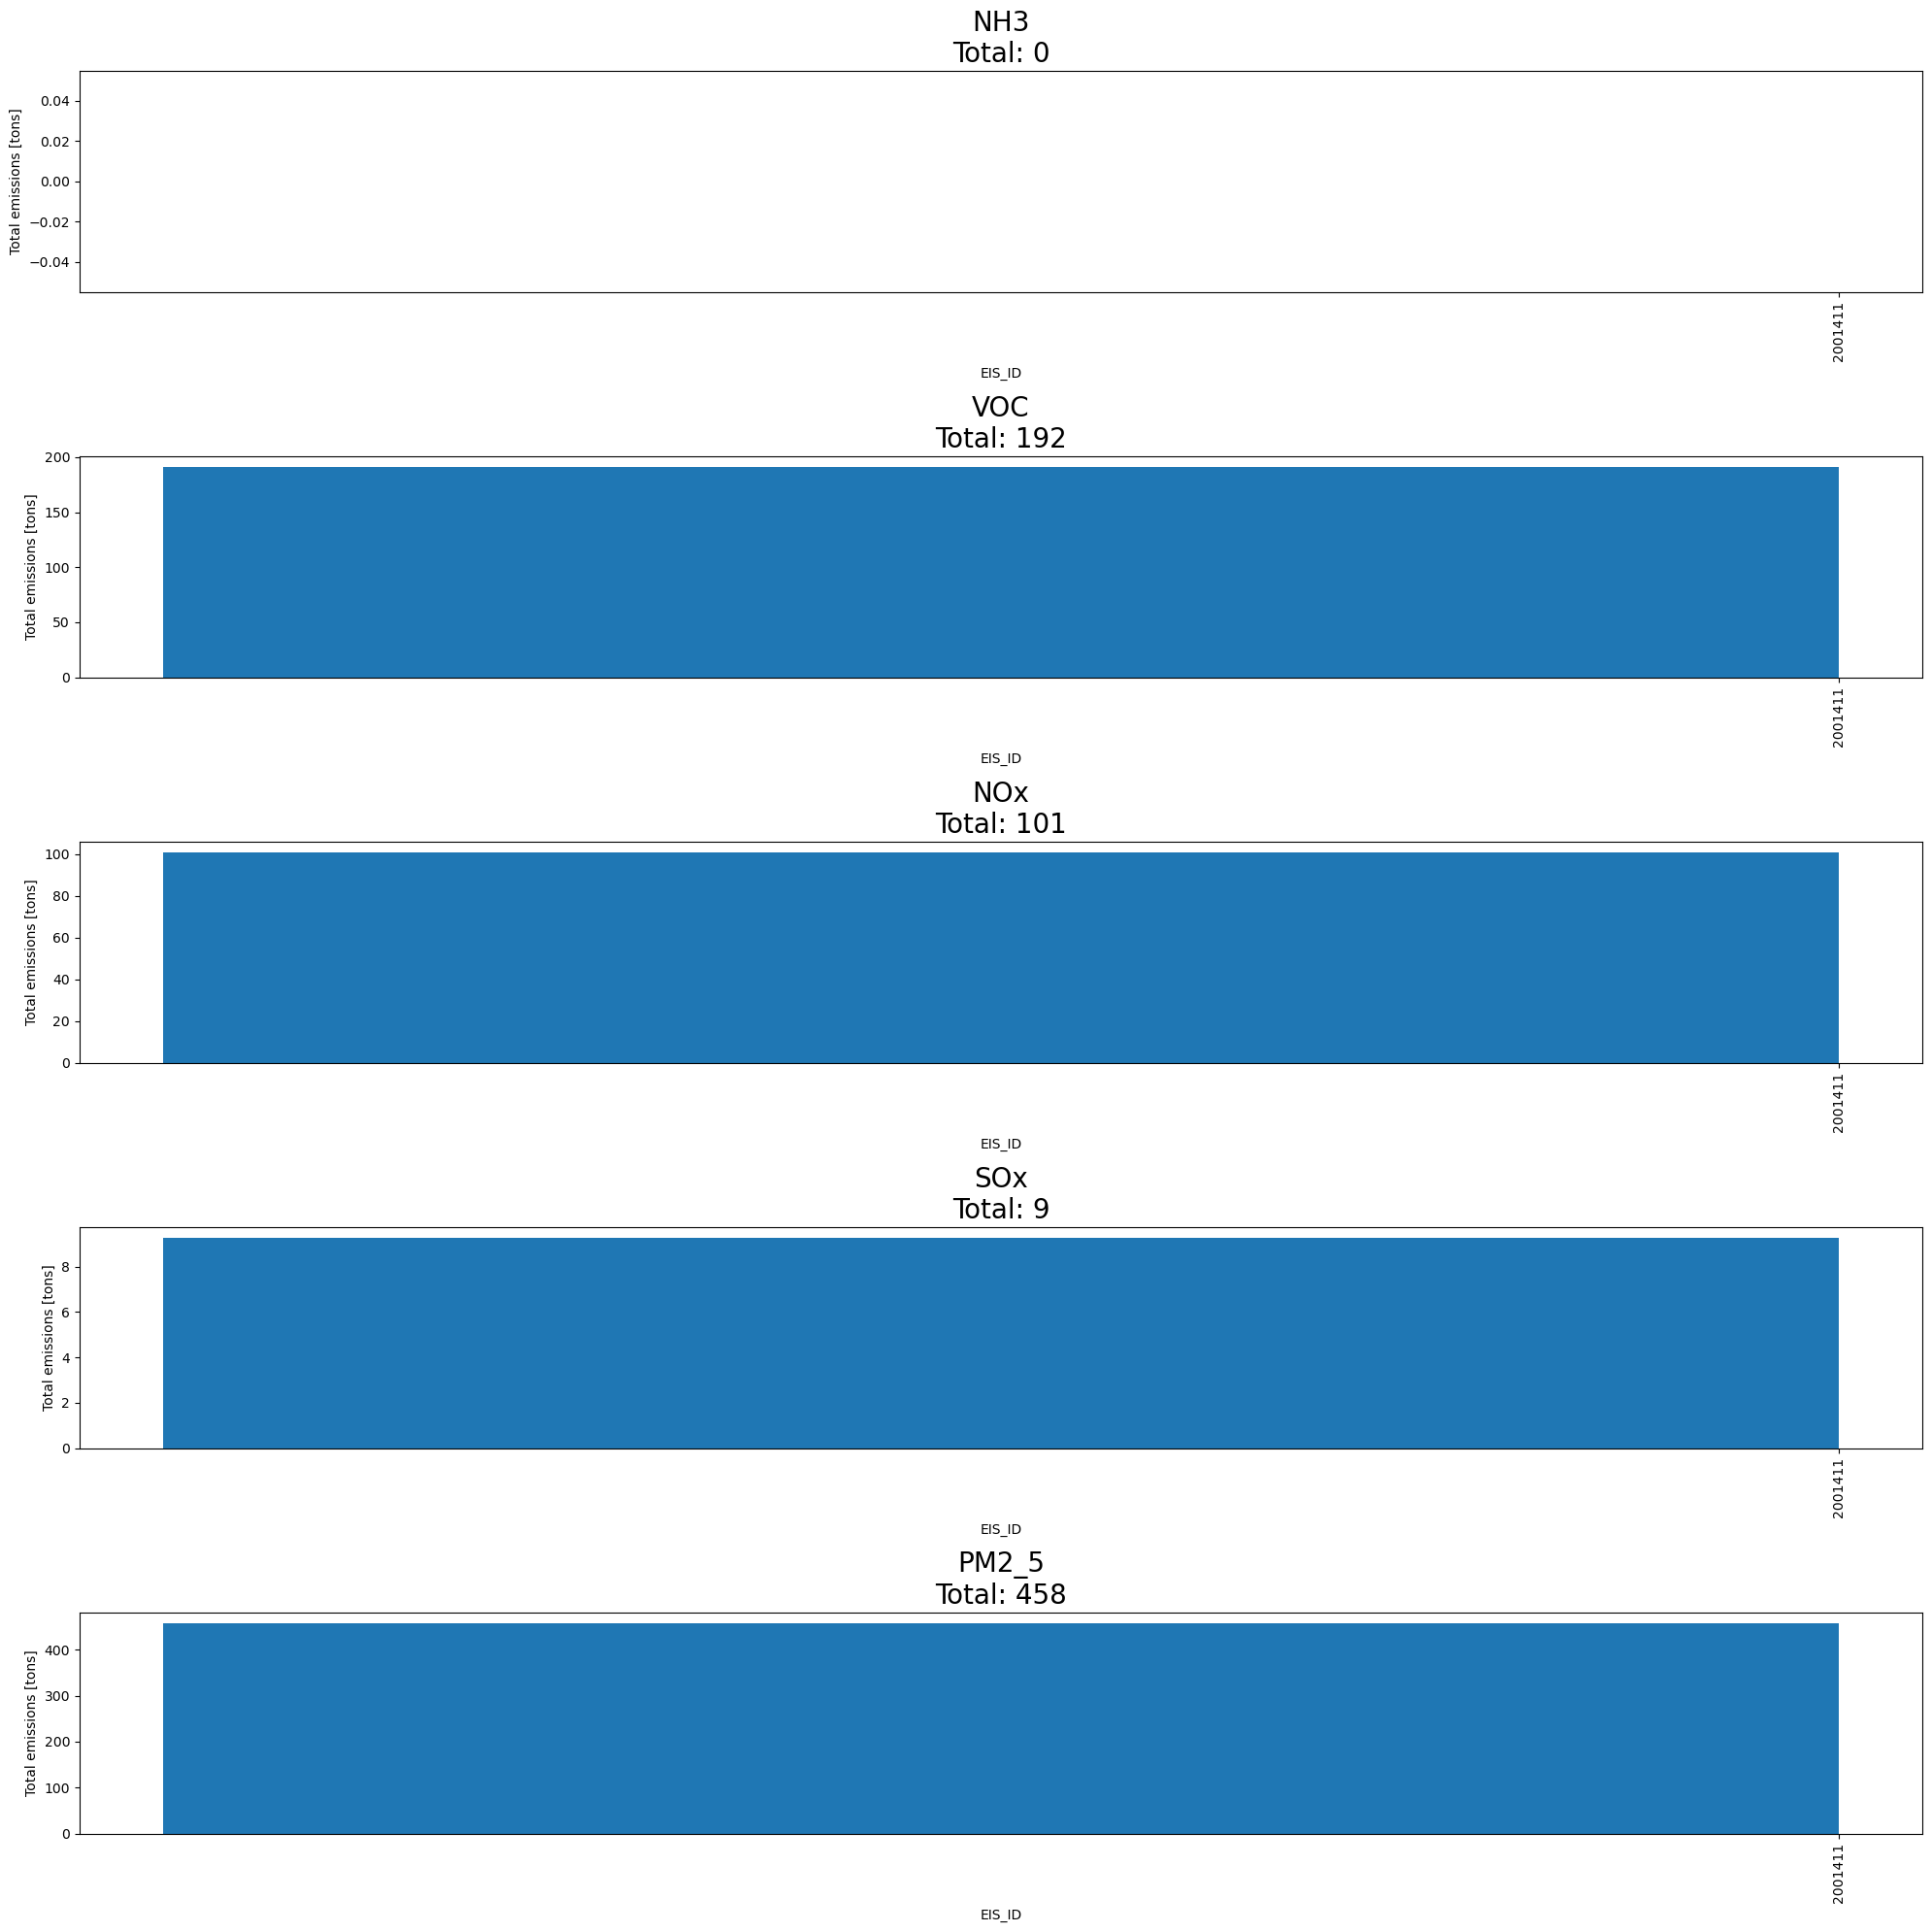

<Figure size 640x480 with 0 Axes>

In [73]:
import geopandas as gpd

# read base and sens emission scenarios
gdf_emis = gpd.read_file('/Users/yunhalee/Documents/LOCAETA/RCM/INMAP/evaldata_v1.6.1/2020_nei_emissions/combined_NEI2020_pt_oilgas_ptegu_ptnonipm.shp')

# Reset index to ensure proper comparison
gdf_emis.reset_index(drop=True, inplace=True)

# Apply CCS emissions to a facility of interest
facility_eis_id = {'Landfill': 2001411} # 'Suncor':1099511 } # 'Cherokee':3555811 } 
                   #'Suncor':1099511, } # 17445711} # Suncor frs_id = '1007923'
		# Cherokee plant alone (facility ID 1007207)  EIS_ID = 17445711
        # NEI emission without landfill facility ID 1007709

for key, id in facility_eis_id.items():

    if isinstance(id, int):
        print(f"{id} is integer")
    else:
        print(f"{id} must be integer")
        id = int(id)

    print(f"matching facility: {gdf_emis[gdf_emis['EIS_ID'] == id]}" )

    subset_df = gdf_emis[gdf_emis['EIS_ID'] == id]


# sum by FIPS
grouped_df = subset_df.drop(columns='geometry').groupby('EIS_ID').sum().reset_index()

pollutants = ['NH3', 'VOC', 'NOx',  'SOx', 'PM2_5'] # 

# Calculate total sums for each pollutant
totals ={pollutant: subset_df[pollutant].sum() for pollutant in pollutants}

# Plotting
fig, axes = plt.subplots(nrows=len(pollutants), ncols=1, figsize=(20, 20) ) #, sharey=True)
bar_width = 0.35  # Width of the bars
for i, pollutant in enumerate(pollutants):
    ax = axes[i]
    indices = np.arange(len(grouped_df))
    # Plot CCS emissions
    ax.bar(indices, grouped_df[pollutant], bar_width, label=f'{pollutant}')

    total = totals[f'{pollutant}']
    ax.set_title(f'{pollutant}\nTotal: {total:.0f}', fontsize=20)
    ax.set_xlabel('EIS_ID')
    ax.set_ylabel('Total emissions [tons]')
    ax.set_xticks(indices + bar_width / 2)
    ax.set_xticklabels(grouped_df['EIS_ID'], rotation=90)

plt.tight_layout()
plt.show()

plt.savefig(os.path.join(output_dir, f'emissions_at_{facility_eis_id.keys}.png'), dpi=300, bbox_inches='tight')

## 2. INMAP simulation results
